In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
from plotnine import *


project_dir = str(Path(os.getcwd()).parent)
datasets_path = str(Path(os.getcwd()).parent) + "/datasets/"
df = pd.read_csv(datasets_path + "down_detector_outage_count.csv")
df_2018 = pd.read_parquet(datasets_path + "2018_fixed_sesaeet.parquet")
df_2019 = pd.read_parquet(datasets_path + "2019_fixed_sesaeet.parquet")
df_2020 = pd.read_parquet(datasets_path + "2020_fixed_sesaeet.parquet") # When 2020 is cleaned and ready
df_vendor = df_2019.append(df_2018).sort_values("event_start_time", inplace=False).reset_index(inplace=False, drop=True)
df_vendor = df_2020.append(df_vendor).sort_values("event_start_time", inplace=False).reset_index(inplace=False, drop=True)

In [4]:

def extract_failure_event_times(partial_df):
    start_time = None
    end_time = None
    num_reports_list = []
    failure_events = []
    page_ids = partial_df.sort_values("timestamp")['event_id'].unique()

    q_val = 0.75
    # Extract event_start and event_end from each event
    event_id = 0
    for page_id in page_ids:
        df_page = partial_df[partial_df["event_id"] == page_id].sort_values("timestamp")
        threshold = df_page["count"].quantile(q_val) 
        while threshold == 0:
            q_val += 0.05
            threshold = df_page["count"].quantile(q_val)
        
        for i, page in df_page.sort_values("timestamp").iterrows():
            nr_reports = page['count']
            event_time = page['timestamp']
            vendor = page['provider']

            if nr_reports > threshold:
                if start_time == None:
                    start_time = event_time

                num_reports_list.append(nr_reports)

            else:
                if start_time != None:
                    end_time = event_time
                    if 900 * 95 > end_time - start_time > 0: # If duration is longer than 23:45, don't add it.
                        failure_events.append({
                            'start_time': start_time,
                            'end_time': end_time,
                            'duration': end_time-start_time,
                            'peak': np.max(num_reports_list),
                            'threshold': threshold,
                            'median': np.median(num_reports_list),
                            'mean': np.mean(num_reports_list),
                            'page_id': page_id,
                            'event_id': event_id,
                            'vendor': vendor
                        })
                        event_id += 1
                        
                    start_time = None
                    end_time = None
                    num_reports_list = []
                    
    return pd.DataFrame(failure_events)

In [5]:
df_user = extract_failure_event_times(df)

df_user["start_datetime"] = pd.to_datetime(df_user["start_time"], unit="s")
df_user["start_date"] = df_user["start_datetime"].dt.date
df_user["start_time"] = df_user["start_datetime"].dt.time

df_user["start_time"] = df_user["start_time"].astype(str)
df_user["start_date"] = df_user["start_date"].astype(str)

df_vendor["event_start_date"] = df_vendor["event_start_time"].dt.date 
df_vendor["event_time_only"] = df_vendor["event_start_time"].dt.time 

df_vendor["event_start_date"] = df_vendor["event_start_date"].astype(str)
df_vendor["event_time_only"] = df_vendor["event_time_only"].astype(str)

<ipython-input-4-26dcbe3996f2>:23: UserWarning: FixedFormatter should only be used together with FixedLocator


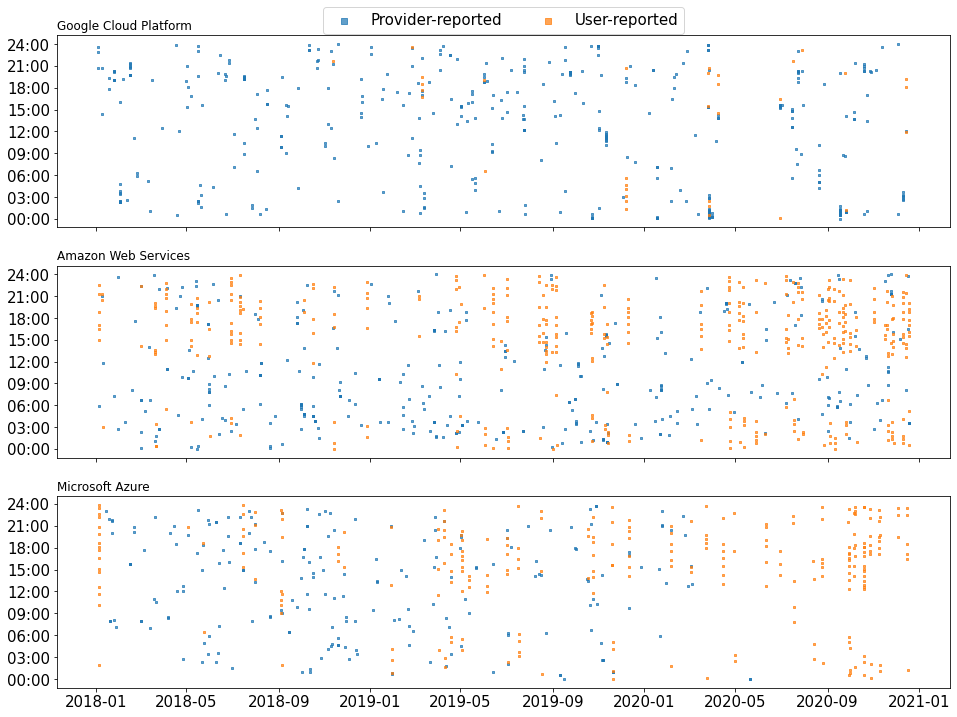

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(3, 1, figsize=(16,12), sharex=True)

vendor_map = {
    'AWS': 'Amazon Web Services',
    "Azure": 'Microsoft Azure',
    'GCP': 'Google Cloud Platform'
}
for i, vendor in enumerate(df_vendor['vendor'].unique()):
    x_v = mdates.datestr2num(df_vendor[df_vendor['vendor']==vendor]["event_start_date"].values)
    y_v = mdates.datestr2num(df_vendor[df_vendor['vendor']==vendor]["event_time_only"].values)
    x_u = mdates.datestr2num(df_user[df_user['vendor']==vendor.lower()]["start_date"].values)
    y_u = mdates.datestr2num(df_user[df_user['vendor']==vendor.lower()]["start_time"].values)
    
    ax[i].set_title(vendor_map[vendor], loc='left')
    ax[i].scatter(x_v, y_v, s=4, label='Provider-reported', marker='s', alpha=0.7)
    ax[i].scatter(x_u, y_u, s=4, label='User-reported', marker='s', alpha=0.7)
    ax[i].yaxis_date()
    ax[i].xaxis_date()
    labels = [item.get_text() for item in ax[i].get_yticklabels()]
    labels = ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00', '24:00']
    ax[i].set_yticklabels(labels)

    ax[i].tick_params(axis='both', labelsize=15)
    ax[0].legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.08), fontsize=15, markerscale=3)

plt.savefig(project_dir + "/plots/vendors_failure_comparison.pdf", dpi=100)
    
# ytickformat('%.2f')

<ipython-input-6-6ef2b9893de3>:18: UserWarning: FixedFormatter should only be used together with FixedLocator


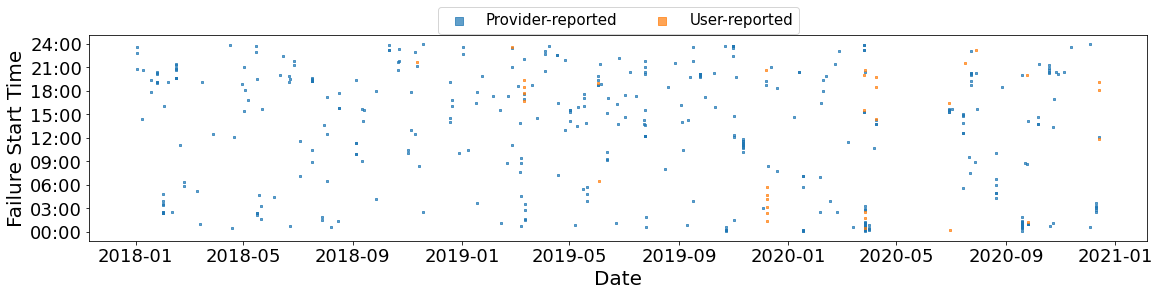

In [6]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, 1, figsize=(16, 4), constrained_layout=True)
x_v = mdates.datestr2num(df_vendor[df_vendor['vendor']=='GCP']["event_start_date"].values)
y_v = mdates.datestr2num(df_vendor[df_vendor['vendor']=='GCP']["event_time_only"].values)
x_u = mdates.datestr2num(df_user[df_user['vendor']=='gcp']["start_date"].values)
y_u = mdates.datestr2num([df_user[df_user['vendor']=='gcp']["start_time"].values])


ax.scatter(x_v, y_v, s=8.5, label='Provider-reported', marker='s', alpha=0.7)
ax.scatter(x_u, y_u, s=8.5, label='User-reported', marker='s', alpha=0.7)
ax.set_ylabel("Failure Start Time", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.yaxis_date()
ax.xaxis_date()
labels = [item.get_text() for item in ax.get_yticklabels()]
labels = ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00', '24:00']
ax.set_yticklabels(labels)

ax.tick_params(axis='both', labelsize=18)
ax.legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.07), fontsize=15, markerscale=3)

plt.savefig(project_dir + "/plots/gcp_failure_comparison.pdf", dpi=100)